In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv(r'C:\Users\Monika\Downloads\saas_funnel_data.csv')

In [4]:
df.head()

,user_id,step_name,timestamp,device,region
0,u0001,Landing Page Visit,2025-03-02 02:46:00,tablet,India
1,u0001,Free Sign-Up,2025-03-02 03:06:00,tablet,India
2,u0001,Email Verification,2025-03-02 03:35:00,tablet,India
3,u0002,Landing Page Visit,2025-03-02 02:50:00,tablet,Brazil
4,u0002,Free Sign-Up,2025-03-02 02:58:00,tablet,Brazil


In [5]:
# Unique steps in the funnel
df['step_name'].unique()


array(['Landing Page Visit', 'Free Sign-Up', 'Email Verification',
       'Feature Usage', 'Upgrade to Paid Plan'], dtype=object)

In [11]:
funnel_order = [
    'Landing Page Visit',
    'Free Sign-Up',
    'Email Verification',
    
]


In [7]:
# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by user and time
df = df.sort_values(by=['user_id', 'timestamp'])


In [8]:
# Keep only the first time each user completed each step
step_df = df.drop_duplicates(subset=['user_id', 'step_name'])

In [9]:
# Count number of unique users at each funnel step
funnel_counts = step_df['step_name'].value_counts().reindex(funnel_order)


In [12]:
# Create a DataFrame for plotting
funnel_df = pd.DataFrame({
    'step': funnel_counts.index,
    'users': funnel_counts.values
})

funnel_df

,step,users
0,Landing Page Visit,1000.0
1,Free Sign-Up,870.0
2,Email Verification,587.0
3,Product Tour,NaN
4,Converted to Premium,NaN


In [13]:
funnel_counts = step_df['step_name'].value_counts().reindex(funnel_order)

funnel_df = pd.DataFrame({
    'step': funnel_counts.index,
    'users': funnel_counts.values
})


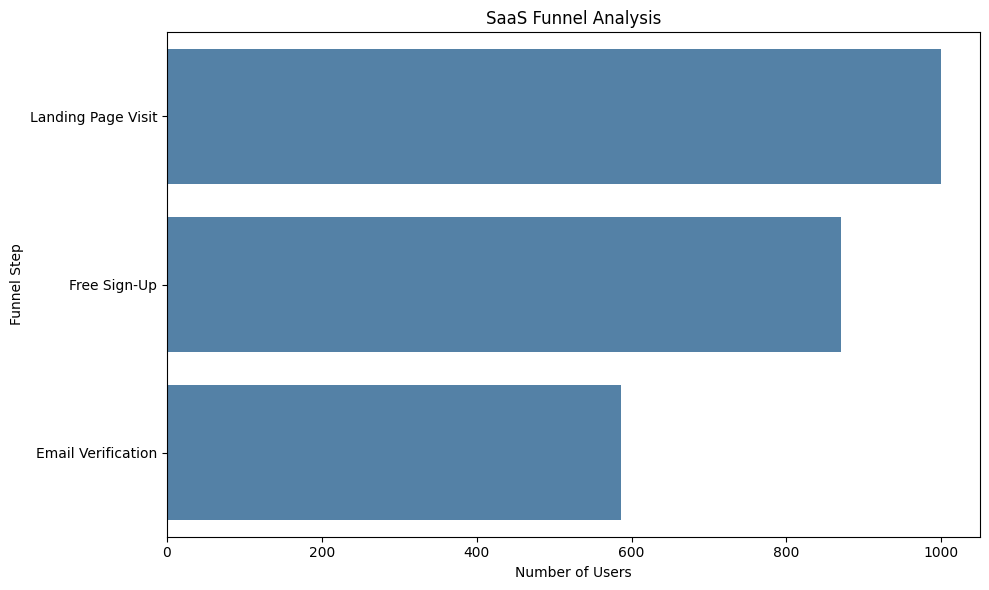

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(x='users', y='step', data=funnel_df, color='steelblue')  # use a single color
plt.title('SaaS Funnel Analysis')
plt.xlabel('Number of Users')
plt.ylabel('Funnel Step')
plt.tight_layout()
plt.savefig('funnel_chart.png')
plt.show()


In [16]:
funnel_df['dropoff'] = funnel_df['users'].shift(1) - funnel_df['users']
funnel_df['dropoff_rate (%)'] = (funnel_df['dropoff'] / funnel_df['users'].shift(1) * 100).round(2)
funnel_df


,step,users,dropoff,dropoff_rate (%)
0,Landing Page Visit,1000,NaN,NaN
1,Free Sign-Up,870,130.0,13.00
2,Email Verification,587,283.0,32.53


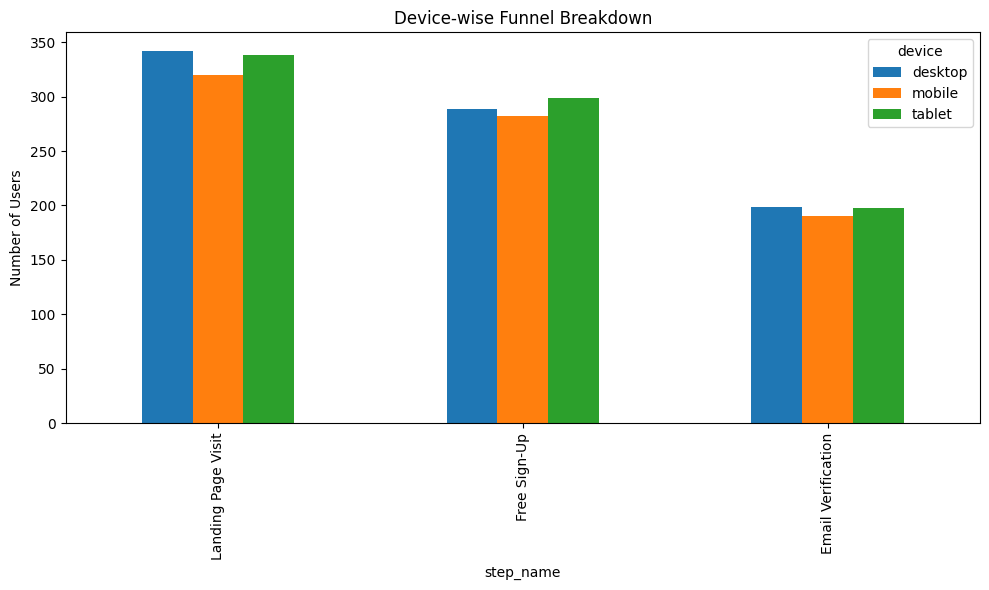

In [17]:
# Pivot table: step counts by device
device_funnel = step_df.pivot_table(index='step_name', columns='device', values='user_id', aggfunc='nunique')
device_funnel = device_funnel.reindex(funnel_order)

device_funnel.plot(kind='bar', figsize=(10,6))
plt.title('Device-wise Funnel Breakdown')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


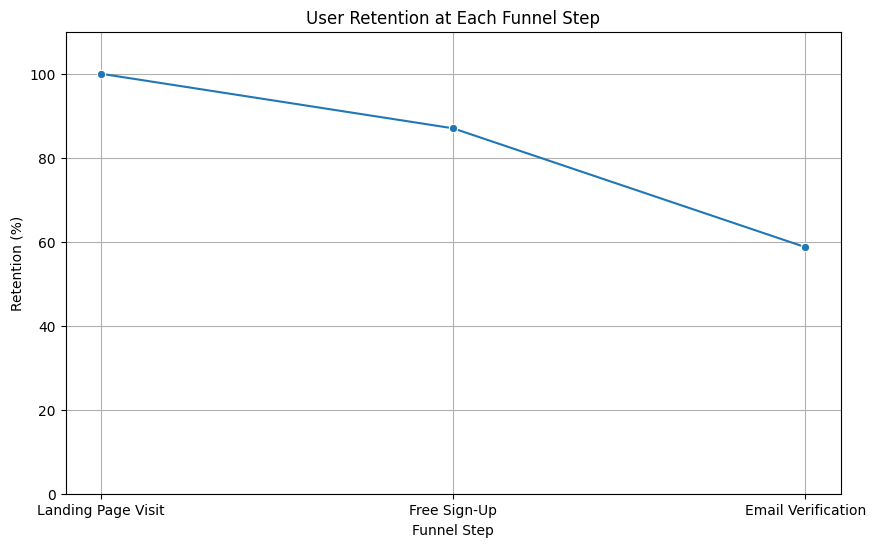

In [28]:
funnel_df['retention'] = (funnel_df['users'] / funnel_df['users'].iloc[0]) * 100

plt.figure(figsize=(10,6))
sns.lineplot(x='step', y='retention', data=funnel_df, marker='o')
plt.title('User Retention at Each Funnel Step')
plt.ylabel('Retention (%)')
plt.xlabel('Funnel Step')
plt.ylim(0, 110)
plt.grid(True)

plt.savefig('dropoff_chart.png')
plt.show()


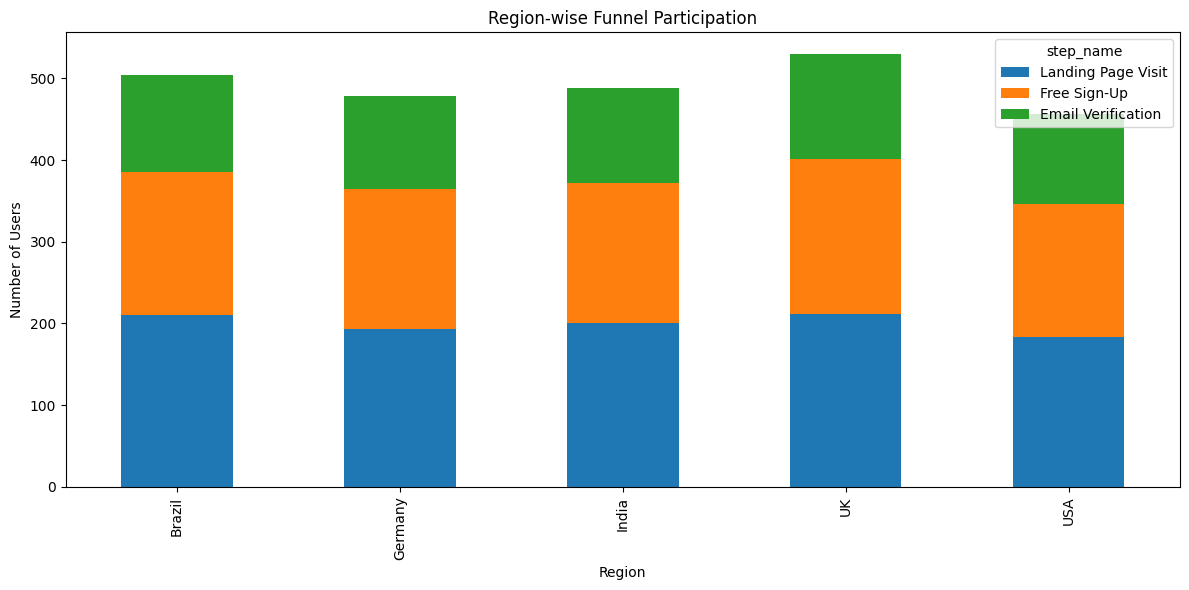

In [19]:
region_step_counts = step_df.groupby(['region', 'step_name'])['user_id'].nunique().unstack().fillna(0)
region_step_counts = region_step_counts[funnel_order]  # ensure correct order

region_step_counts.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Region-wise Funnel Participation')
plt.xlabel('Region')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


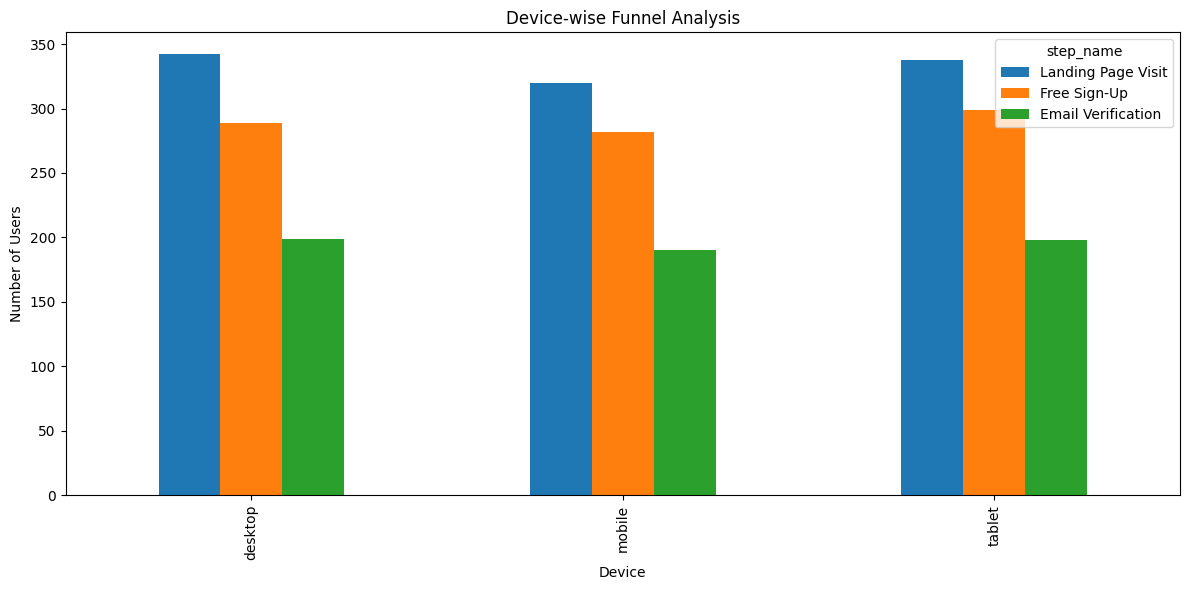

In [20]:
device_step_counts = step_df.groupby(['device', 'step_name'])['user_id'].nunique().unstack().fillna(0)
device_step_counts = device_step_counts[funnel_order]

device_step_counts.plot(kind='bar', figsize=(12,6))
plt.title('Device-wise Funnel Analysis')
plt.xlabel('Device')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


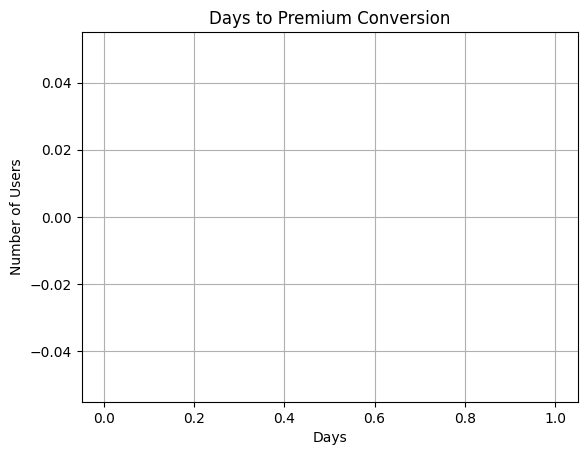

In [21]:
converted_users = step_df[step_df['step_name'] == 'Converted to Premium']
signup_users = step_df[step_df['step_name'] == 'Free Sign-Up']

merged = pd.merge(signup_users, converted_users, on='user_id', suffixes=('_signup', '_premium'))
merged['time_to_convert'] = (merged['timestamp_premium'] - merged['timestamp_signup']).dt.days

merged['time_to_convert'].hist(bins=20)
plt.title('Days to Premium Conversion')
plt.xlabel('Days')
plt.ylabel('Number of Users')
plt.show()


In [23]:
import numpy as np

# Define % of users who should take the product tour (say 60% of email verified users)
email_verified_users = step_df[step_df['step_name'] == 'Email Verification']['user_id'].unique()
product_tour_users = np.random.choice(email_verified_users, size=int(0.6 * len(email_verified_users)), replace=False)

# Create 'Product Tour' rows
product_tour_df = pd.DataFrame({
    'user_id': product_tour_users,
    'step_name': 'Product Tour',
    'timestamp': pd.to_datetime('2023-09-20') + pd.to_timedelta(np.random.randint(1, 3, len(product_tour_users)), unit='D'),
    'device': 'unknown',  # can copy from earlier if needed
    'region': 'unknown'
})

# Define % of users who convert to premium (say 30% of product tour users)
converted_users = np.random.choice(product_tour_users, size=int(0.3 * len(product_tour_users)), replace=False)

# Create 'Converted to Premium' rows
premium_df = pd.DataFrame({
    'user_id': converted_users,
    'step_name': 'Converted to Premium',
    'timestamp': pd.to_datetime('2023-09-22') + pd.to_timedelta(np.random.randint(1, 3, len(converted_users)), unit='D'),
    'device': 'unknown',
    'region': 'unknown'
})

# Append to main df and sort again
df_extended = pd.concat([df, product_tour_df, premium_df])
df_extended = df_extended.sort_values(by=['user_id', 'timestamp'])



In [24]:
df_extended.to_csv("extended_funnel.csv", index=False)


In [26]:
# Create features: sessions per user at each stage
features = df_extended.groupby(['user_id', 'step_name']).size().unstack(fill_value=0)

# Label users who reached 'Converted to Premium'
features['converted'] = features['Converted to Premium'].apply(lambda x: 1 if x > 0 else 0)

# Drop 'Converted to Premium' as input
X = features.drop(columns=['Converted to Premium', 'converted'])
y = features['converted']

# Train model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))



              precision    recall  f1-score   support

           0       0.91      1.00      0.95       181
           1       0.00      0.00      0.00        19

    accuracy                           0.91       200
   macro avg       0.45      0.50      0.48       200
weighted avg       0.82      0.91      0.86       200



In [29]:
import os
os.getcwd()


'C:\\Users\\Monika'